# Optimizing ellipse detection

**Methods:**
>1. Load data
>2. Classify ellipses with original parameters
>3. Calculate the fraction of 1s and 7s with 1 ellipse vs. all others
>4. Calculate the fraction of 0s, 6s and 9s with 2 ellipses vs. all others
>5. Calculate the fraction of 8s with 3 ellipses vs. all others
>6. Tweak the parameters to get the highest fraction of those apps with the correct # of ellipses

**Conclusion:**
* No improvement from tweaking parameters related to cv.findContours

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
import seaborn as sns
sns.set_context(context = 'notebook', font_scale=1.5)
import os
import sys
import cv2

base_path = '/home/lundi/Python/MNIST/'
sys.path.append(base_path + '/libraries/')

import MNIST_data_processor as mdp

MNIST_data_processor = mdp.MNIST_data_processor()

from matplotlib.patches import Ellipse

## 1. Load data

In [2]:
X, y = MNIST_data_processor.load_subset_data()

## 2. Classify ellipses with original parameters

In [14]:
def convert_to_image(data):
    img = np.zeros((28, 28,3))
    img[:,:,0] = data.reshape(28,28)
    img[:,:,1] = data.reshape(28,28)
    img[:,:,2] = data.reshape(28,28)
    
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

def get_distance_between_ellipses(ellipse_1, ellipse_2):
    return np.sqrt(((ellipse_1[0][0] - ellipse_2[0][0]) ** 2) + ((ellipse_1[0][1] - ellipse_2[0][1]) ** 2))

def get_ellipse_count(digit_data):
    image = convert_to_image(digit_data)
    
    ret,thresh = cv2.threshold(image,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    valid_contours = []
    #Get the valid contours
    for cnt in contours:
        if len(cnt) >= 5:
            valid_contours.append(cnt)
    return len(valid_contours)

def get_ellipse(digit_data):
    image = convert_to_image(digit_data)
    
    ret,thresh = cv2.threshold(image,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    valid_contours = []
    #Get the valid contours
    for cnt in contours:
        if len(cnt) >= 5:
            valid_contours.append(cnt)
    return valid_contours

## 3. Calculate the fraction of 1s and 7s with 1 ellipse vs. all others

In [7]:
ellipse_count_data = pd.concat([X.apply(get_ellipse_count, axis=1), y], axis=1).replace(-1, np.nan).dropna()
ellipse_count_data = ellipse_count_data.rename(columns = {0: 'ellipse_count'})

In [13]:
ellipse_count_crosstab = pd.crosstab(ellipse_count_data['ellipse_count'], ellipse_count_data['label'])

(ellipse_count_crosstab / ellipse_count_crosstab.sum(axis=0)).round(2)

label,0,1,2,3,4,5,6,7,8,9
ellipse_count,,,,,,,,,,
0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.13,0.99,0.63,0.95,0.94,0.88,0.24,0.99,0.04,0.21
2,0.85,0.00,0.37,0.04,0.06,0.11,0.73,0.01,0.32,0.78
3,0.02,0.00,0.01,0.00,0.00,0.01,0.03,0.00,0.62,0.01
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


* 1s look pretty good, 99% of 1s have 1 ellipse
* 7s also have 99% with 1 ellipse, which is problematic. This means I need a way to distinguish these two numbers with a dummy variable
* I should do the dummy variable idea where I 

Let's look at some 7s and some 1s

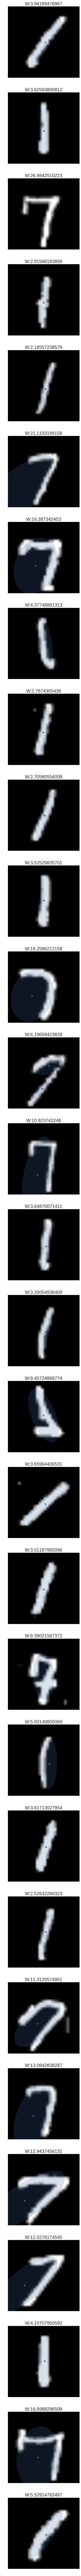

In [43]:
number_indexes = np.bitwise_or( (y == 1),  (y == 7) )
X_subset = X.loc[number_indexes].head(30)

plt.figure(figsize=(5, 6 * X_subset.shape[0]))
counter = 0
for index, current_digit_data in X_subset.iterrows():
    valid_contours = get_ellipse(current_digit_data)
    plt.subplot(X_subset.shape[0], 1, (counter+1))
    counter+=1

    image = convert_to_image(current_digit_data)
    # ensure at least some circles were found
    
    for cnt in valid_contours:
        ellipse = cv2.fitEllipse(cnt)
        #print 'xy', ellipse[0]
        #print 'area:', ellipse[1][0] * ellipse[1][1] * np.pi
        #print 'W:', ellipse[1][0]
        #print 'H:', ellipse[1][1]
        ellipse_matplot = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2])
        ax = plt.gca()
        ax.add_artist(ellipse_matplot)
        ellipse_matplot.set_clip_box(ax.bbox)
        ellipse_matplot.set_alpha(0.2)

        ellipse_matplot = Ellipse(xy=ellipse[0], width=0.6, height=0.6, angle=0)
        ax.add_artist(ellipse_matplot)
        ellipse_matplot.set_clip_box(ax.bbox)

        ax.set_title('W:' + str(ellipse[1][0]))

        ax.axis('off')
    plt.imshow(255 - image)

This shows that 7s tend to have much larger widths than 1s, I can add this to the dummy variable. 

This is actually a tangent, I wanted to adjust the ellipse parameters to see if I couldn't get better ellipse counts for 1s and 7s:

In [101]:
def get_ellipse_count(digit_data):
    image = convert_to_image(digit_data)
    
    ret,thresh = cv2.threshold(image,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    #Get the valid contours
    for cnt in contours:
        if len(cnt) >= 5:
            valid_contours.append(cnt)
    return len(valid_contours)

def get_threshold_image(digit_data):
    image = convert_to_image(digit_data)
    
    ret,thresh = cv2.threshold(image,0,255,0)
    return thresh

In [102]:
ellipse_count_data = pd.concat([X.apply(get_ellipse_count, axis=1), y], axis=1).replace(-1, np.nan).dropna()
ellipse_count_data = ellipse_count_data.rename(columns = {0: 'ellipse_count'})
ellipse_count_crosstab = pd.crosstab(ellipse_count_data['ellipse_count'], ellipse_count_data['label'])

(ellipse_count_crosstab / ellipse_count_crosstab.sum(axis=0)).round(2)

label,0,1,2,3,4,5,6,7,8,9
ellipse_count,,,,,,,,,,
0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.13,0.99,0.63,0.95,0.94,0.88,0.24,0.99,0.04,0.21
2,0.85,0.00,0.37,0.04,0.06,0.11,0.73,0.01,0.32,0.78
3,0.02,0.00,0.01,0.00,0.00,0.01,0.03,0.00,0.62,0.01
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


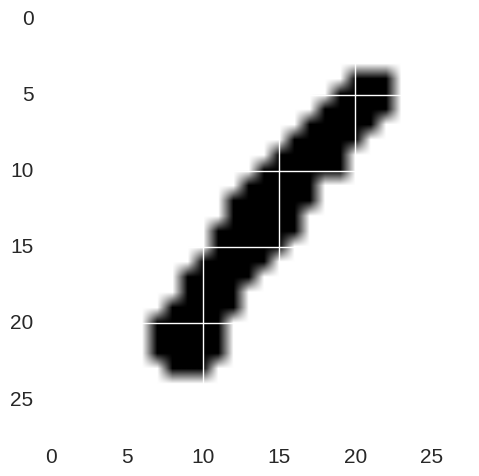

In [75]:
img = get_threshold_image(X_subset.ix[0])
plt.imshow(img)

## 4. Calculate the fraction of 0s, 6s and 9s with 2 ellipses vs. all others

## 5. Calculate the fraction of 8s with 3 ellipses vs. all others

## 6. Tweak the parameters to get the highest fraction of those apps with the correct # of ellipses

#### Attempted to but could not improve this